- Takes as input the (768, 768, 64) images from `dataset-1`.
- It takes 4^3 average across the 2D, and average across the depth
- This results in a (192, 192, 16) volume.
- I have a image that is of shape (1, 192, 192, 16). Divide the image and the labels into 32 patches: (1, 8*24, 8*24, 16) → (24, 24, 1024) → (576, 1024). 
- Pass the image into a transformer architecture with 6 layers, which will return (576, 1) tensor, which corresponds to probabilities of pixel occuring. You should also pass the “positional embeddings”, which should be of dimension 1024.

# 4^3 3D average 


In [1]:
import numpy as np
import torch
import torch.nn as nn

def avg_3d(volume):
    # Convert the numpy array to a PyTorch tensor
    volume_tensor = torch.tensor(volume, dtype=torch.float32)

    # Add batch and channel dimensions to the tensor
    volume_tensor = volume_tensor.permute(0, 3, 1, 2)  # Reorder dimensions to (batch, channels, height, width)

    # Create the 3D average pooling layer with the appropriate kernel size and stride values
    avg_pool = nn.AvgPool3d(kernel_size=4, stride=4, padding=0)

    # Apply the average pooling layer to the input tensor
    with torch.no_grad():
        filtered_volume_tensor = avg_pool(volume_tensor)

    # Convert the output tensor back to a numpy array
    filtered_volume = filtered_volume_tensor.permute(0, 2, 3, 1)  # Reorder dimensions back to (batch, height, width, channels)
    
    return filtered_volume


# Example volume
volume = np.random.rand(1, 768, 768, 64)
volume_avgd = avg_3d(volume)
# %time avg_3d(volume) # 85 ms!

In [2]:
volume_avgd.shape

torch.Size([1, 192, 192, 16])

# Take random 3 channels

In [3]:
volume_avgd_new = volume_avgd.permute(3, 1, 2, 0)
# take 3 random numbers between 0 and 16, without replacement
random_numbers = np.random.choice(16, 3, replace=False)
volume_avgd_new = volume_avgd_new[random_numbers, :, :, :]
# Repermute
volume_avgd_new = volume_avgd_new.permute(3, 1, 2, 0)
volume_avgd_new.shape


torch.Size([1, 192, 192, 3])

# Reshape

In [4]:
import numpy as np


def reshape_img(image):
    # Calculate the size of each patch
    patch_size = 24

    B, H, W, C = image.shape
    image = image.reshape(B, H // patch_size, patch_size, W // patch_size, patch_size, C) # (B, 8, 24, 8, 24, 16)
    image = image.permute(0, 2, 4, 1, 3, 5) # (B, 24, 24, 8, 8, 16)
    image = image.reshape(B, patch_size, patch_size, -1) # (B, 24, 24, 1024)
    image = image.reshape(B, -1, 1024) # (B, 576, 1024)
    
    return image

# Example image
image = np.random.rand(2, 192, 192, 16)
image = torch.tensor(image, dtype=torch.float32)


image = reshape_img(image)

print(image.shape)


torch.Size([2, 576, 1024])


# Metric competition


In [5]:
def f0point5_score(output, target):
    # Flatten the output and target tensors
    output = output.view(-1)
    target = target.view(-1)
    
    # Convert the output to binary values 0 and 1
    output = (output > 0.5).float()
    
    # Calculate the precision and recall
    tp = torch.sum(output * target)
    fp = torch.sum(output * (1 - target))
    fn = torch.sum((1 - output) * target)
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    
    # Calculate the F0.5 score
    beta = 0.5
    f0point5 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-7)
    return f0point5

# Model: ResNet50Seg

In [6]:
import torch.nn as nn
import torchvision.models as models

class ResNet50Seg(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, class_one_weight=1):
        super(ResNet50Seg, self).__init__()
        
        self.class_one_weight = class_one_weight
        
        # Load the pre-trained ResNet50 model
        self.resnet50 = models.resnet50()
        
        # Replace the final layer to output 1024 channel instead of 1000
        self.resnet50.fc = nn.Linear(2048, 1024)
        
        
    def forward(self, x, targets=None):
        x = self.resnet50(x)
        # Apply sigmoid
        x = torch.sigmoid(x)
        
        out = {}
        
        if targets is None:
            loss = None
            precision = None
            accuracy = None
            f0point5 = None
        else:
            # Calculate the loss
            
            # Calculate class weights based on the imbalance
            class_weights = torch.tensor([1.0, self.class_one_weight]) # weight 1 for class 0, weight 5 for class 1

            # Instantiate the loss function
            loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights[1], reduction='mean')
            
            # Flatten the targets tensor
            targets = targets.reshape(-1, 1024)
            
            # Calculate the loss
            loss = loss_function(x, targets)
            
            # Calculate the accuracy: number of correctly predicted pixel / total number of pixels
            # Convert the predictions to binary values 0 and 1
            predictions = (x > 0.5).float()
            # Calculate the accuracy
            accuracy = (predictions == targets).float().mean()
            
            # Calculate the precision
            tp = torch.sum(predictions * targets)   
            fp = torch.sum(predictions * (1 - targets))
            fn = torch.sum((1 - predictions) * targets)
            precision = tp / (tp + fp + 1e-7)
            
            # Calculate F0.5 score
            f0point5 = f0point5_score(predictions, targets) 
        
        out = {
            "loss": loss,
            "logits": x,
            "accuracy": accuracy,
            "precision": precision,
            "f0point5": f0point5
        }
        
        return out


In [7]:
model = ResNet50Seg(in_channels=3, out_channels=1)
x = torch.randn(1, 3, 192, 192)  # input image
output = model(x)
output['logits'].shape

torch.Size([1, 1024])

In [8]:
# number of 1e6 parameters
sum(p.numel() for p in model.parameters()) / 1e6

25.606208

# Mode: UNet

In [60]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=32, out_channels=1, init_features=64, pretrained=False)

# example image
image = torch.randn(1, 32, 192, 192)  # input image

output = model(image)
output.shape

Using cache found in /Users/viktorcikojevic/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


torch.Size([1, 1, 192, 192])

In [49]:
from torchsummary import summary

summary(model, (32, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           9,216
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

In [37]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)

# example image
image = torch.randn(1, 192, 192, 16)  # input image

# Make 3 dense layers that will make the number of channels from 16 to 3
dense1 = nn.Linear(16, 16)
dense2 = nn.Linear(16, 8)
dense3 = nn.Linear(8, 3)

image = image.reshape(-1, 16)  # Flatten the image
image = dense1(image)  # Apply the first dense layer
# relu
image = torch.max(image, torch.zeros_like(image))
image = dense2(image)  # Apply the second dense layer
image = torch.max(image, torch.zeros_like(image))
image = dense3(image)  # Apply the third dense layer
image = torch.max(image, torch.zeros_like(image))

# reshape to (1, 192, 192, 3)
image = image.reshape(1, 192, 192, 3)
# permute to (1, 3, 192, 192)
image = image.permute(0, 3, 1, 2)

output = model(image)
output.shape

Using cache found in /Users/viktorcikojevic/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


torch.Size([1, 1, 192, 192])

In [53]:
indices = np.random.choice(64, 16, replace=False)
indices = np.sort(indices)
indices

array([ 3,  5,  8, 10, 15, 18, 20, 26, 28, 29, 31, 32, 35, 42, 48, 60])

# Model: Unet (tests for a script)

In [80]:
import torch
import torch.nn as nn
import torchvision.models as models

class UNet(nn.Module):
    def __init__(self, img_width=384, in_channels=16, out_channels=1, init_features=64, class_one_weight=1):
        super(UNet, self).__init__()
        
        self.img_width = img_width
        self.class_one_weight = class_one_weight
        
        # Load the pre-trained UNet model
        self.unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=in_channels, out_channels=out_channels, init_features=init_features, pretrained=False)
        
    def forward(self, x, targets=None):
        x = self.unet(x)
        # Convert the predictions to binary values 0 and 1
        predictions = (x > 0.5).float()
        
        out = {}
        
        if targets is None:
            loss = None
            precision = None
            accuracy = None
            f0point5 = None
        else:
            # Calculate the loss
            
            # Calculate class weights based on the imbalance
            class_weights = torch.tensor([1.0, self.class_one_weight]) # weight 1 for class 0, weight 5 for class 1

            # Instantiate the loss function
            loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights[1], reduction='mean')
            
            # Flatten the targets and x tensor
            targets = targets.reshape(-1, int(self.img_width ** 2))
            x = x.reshape(-1, int(self.img_width ** 2))
            predictions_flat = predictions.reshape(-1, int(self.img_width ** 2))
            
            # Calculate the loss
            loss = loss_function(x, targets)
            
            # Calculate the accuracy: number of correctly predicted pixel / total number of pixels
            # Calculate the accuracy
            accuracy = (predictions_flat == targets).float().mean()
            
            # Calculate the precision
            tp = torch.sum(predictions_flat * targets)   
            fp = torch.sum(predictions_flat * (1 - targets))
            fn = torch.sum((1 - predictions_flat) * targets)
            precision = tp / (tp + fp + 1e-7)
            
            # Calculate F0.5 score
            f0point5 = f0point5_score(predictions_flat, targets) 
        
        out = {
            "loss": loss,
            "logits": x,
            "predictions": predictions,
            "accuracy": accuracy,
            "precision": precision,
            "f0point5": f0point5
        }
        
        return out


In [81]:
model = UNet(in_channels=16, out_channels=1)
# example image
image = torch.randn(1, 16, 192, 192)  # input image

output = model(image)
output

Using cache found in /Users/viktorcikojevic/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


{'loss': None,
 'logits': tensor([[[[0.3822, 0.4928, 0.5304,  ..., 0.5390, 0.5003, 0.4663],
           [0.3897, 0.4987, 0.3285,  ..., 0.4702, 0.4966, 0.4246],
           [0.4077, 0.5033, 0.4310,  ..., 0.5758, 0.3895, 0.4993],
           ...,
           [0.3387, 0.4023, 0.4429,  ..., 0.4360, 0.3875, 0.4244],
           [0.4495, 0.4083, 0.4170,  ..., 0.3509, 0.3790, 0.5283],
           [0.2891, 0.3429, 0.4832,  ..., 0.3691, 0.3413, 0.3569]]]],
        grad_fn=<SigmoidBackward0>),
 'predictions': tensor([[[[0., 0., 1.,  ..., 1., 1., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 1., 0.,  ..., 1., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 1.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'accuracy': None,
 'precision': None,
 'f0point5': None}

In [83]:
model = UNet(img_width=192, in_channels=16, out_channels=1)
# example image
image = torch.randn(1, 16, 192, 192)  # input image
targets = torch.randn(1, 1, 192, 192)  # input image
targets = torch.abs(targets)

output = model(image, targets)
output

Using cache found in /Users/viktorcikojevic/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


{'loss': tensor(0.5615, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'logits': tensor([[0.5646, 0.5351, 0.4979,  ..., 0.5414, 0.4981, 0.4839]],
        grad_fn=<ReshapeAliasBackward0>),
 'predictions': tensor([[[[1., 1., 0.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 0.,  ..., 1., 0., 0.],
           ...,
           [1., 1., 0.,  ..., 1., 1., 1.],
           [0., 1., 1.,  ..., 1., 1., 1.],
           [0., 0., 1.,  ..., 1., 0., 0.]]]]),
 'accuracy': tensor(0.),
 'precision': tensor(0.7952),
 'f0point5': tensor(0.8108)}

# Loss function

In [9]:
# Calculate class weights based on the imbalance
class_weights = torch.tensor([1.0, 5.0]) # weight 1 for class 0, weight 5 for class 1

# Instantiate the loss function
loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights[1], reduction='none')

# Example output and targets
out = [[0.1], [0.2], [0.9], [0.9], [0]]
tar = [[1], [1], [0], [1], [0]]
output = torch.tensor([out], dtype=torch.float32)
targets = torch.tensor([tar], dtype=torch.float32)
loss_function(output, targets)

tensor([[[3.2220],
         [2.9907],
         [1.2412],
         [1.7058],
         [0.6931]]])

In [10]:
# Calculate class weights based on the imbalance
class_weights = torch.tensor([1.0, 5.0]) # weight 1 for class 0, weight 5 for class 1

# Instantiate the loss function
loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights[1], reduction='mean')

# Example output and targets
out = [[0.1], [0.2], [0.9], [0.9], [0]]
tar = [[1], [1], [0], [1], [0]]
output = torch.tensor([out], dtype=torch.float32)
targets = torch.tensor([tar], dtype=torch.float32)
loss_function(output, targets)

tensor(1.9705)

# Model with loss test

In [11]:
model = ResNet50Seg(in_channels=3, out_channels=1)
x = torch.randn(16, 3, 192, 192)  # input image
targets = torch.randn(16, 1024)  # input image

# Normalize x to be between 0 and 1
x = torch.sigmoid(x)

# Clip targets to 0 and 1
targets = torch.clamp(targets, 0, 1)


output = model(x, targets)
output['logits'].shape, output['loss'], output['accuracy']

(torch.Size([16, 1024]),
 tensor(0.8201, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(0.3237))

In [12]:
# Expected value for the BCE loss if there is 1024 elements

# Instantiate the loss function
loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights[1], reduction='mean')

y_true = torch.randn(1024, 1024) 
y_pred = torch.randn(1024, 1024) 

loss = loss_function(y_pred, y_true)
loss

tensor(0.8094)

In [13]:
# Expected value for the BCE loss if there is 1024 elements that were all correctly classified

# Instantiate the loss function
loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights[1], reduction='mean')

y_pred = torch.randn(1024*16, 1024) 

loss = loss_function(y_pred, y_pred)
loss

tensor(-2.1933)

# Overfit on 1 batch of random numbers

In [14]:
from tqdm import tqdm

In [15]:


model = ResNet50Seg(in_channels=3, out_channels=1, class_one_weight=5)
x = torch.randn(4, 3, 192, 192)  # input image
# targets = random integers of shape (4, 1024) between 0 and 1
targets = torch.randint(0, 2, (4, 1024)).float()
# Make 80% of the targets to be 0
targets[:, 0:819] = 0


# Normalize x to be between 0 and 1
x = torch.sigmoid(x)

# Clip targets to 0 and 1
targets = torch.clamp(targets, 0, 1)

# optimizer 
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

n_iters = 450
for i in tqdm(range(n_iters)):
    
    # Forward pass
    output = model(x, targets)
    loss = output['loss']
    precision = output['precision']
    accuracy = output['accuracy']
    f0point5 = output['f0point5']
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}, Precision: {precision.item():.4f}, F0.5: {f0point5.item():.4f}")


  0%|          | 1/450 [00:00<03:06,  2.41it/s]

Loss: 1.1121, Accuracy: 0.4919, Precision: 0.0982, F0.5: 0.1171


  2%|▏         | 11/450 [00:03<02:16,  3.22it/s]

Loss: 1.0670, Accuracy: 0.6594, Precision: 0.2008, F0.5: 0.2367


  5%|▍         | 21/450 [00:06<02:12,  3.25it/s]

Loss: 1.0315, Accuracy: 0.7725, Precision: 0.2935, F0.5: 0.3401


  7%|▋         | 30/450 [00:09<02:19,  3.01it/s]


KeyboardInterrupt: 

# Data Loader

In [84]:
from torch.nn.functional import avg_pool2d
from torch.utils.data import Dataset, DataLoader
import os


class ImageSegmentationDataset(Dataset):
    def __init__(self, root, mode='train', device='cpu', cache_refresh_interval=None, cache_n_images=64):
        
        assert mode in ['train', 'test'], "mode must be either 'train' or 'test'"
        
        self.root = root
        self.mode = mode
        self.cache_refresh_interval = cache_refresh_interval
        self.cache_n_images = cache_n_images
        self._load_data()
        
    def __len__(self):
        return len(self.volume_images)
    
    def _load_data(self):
        # Get the volume paths
        self.volume_images = os.listdir(os.path.join(self.root, self.mode, 'volume'))
        self.volume_images = [os.path.join(self.root, self.mode, 'volume', image) for image in self.volume_images]
        
        # Get label paths
        self.label_images = os.listdir(os.path.join(self.root, self.mode, 'label'))
        self.label_images = [os.path.join(self.root, self.mode, 'label', image) for image in self.label_images]
        
        # take self.cache_n_images random images from the dataset. They cannot be repeated
        if self.cache_n_images is not None and self.cache_n_images < len(self.volume_images):
            self.volume_images = np.random.choice(self.volume_images, size=self.cache_n_images, replace=False)
            self.label_images = np.random.choice(self.label_images, size=self.cache_n_images, replace=False)
        
        # Load the data into memory
        self.cached_data = []
        for volume_image, label_image in zip(self.volume_images, self.label_images):
            volume = np.load(volume_image)
            label = np.load(label_image)
            
            # convert to torch tensors
            volume = torch.tensor(volume, dtype=torch.float32)
            label = torch.tensor(label, dtype=torch.float32)
            
            self.cached_data.append({
                "image": volume,
                "targets": label
            }) 
    
    def __len__(self):
        return len(self.cached_data)
    
    def __getitem__(self, item):
        return self.cached_data[item]
    
    def refresh_cache(self):
        self._load_data()

In [85]:

# Define the dataset and dataloader
root = "../../datasets/dataset-1/"

# Mac m1 device
device = torch.device("mps")

batch_size = 16

dataset = ImageSegmentationDataset(root=root, mode='train', device=device, cache_refresh_interval=160, cache_n_images=batch_size)

In [86]:
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [87]:
# one batch
batch = next(iter(dataloader))
batch['image'].shape, batch['targets'].shape

(torch.Size([16, 384, 384, 16]), torch.Size([16, 384, 384, 1]))

In [88]:
# Let's check how fast the dataloader is

import time

start = time.time()
for i in range(100):
    batch = next(iter(dataloader))
    # Refresh the cache 
    if i % dataset.cache_refresh_interval == 0:
        dataset.refresh_cache()
    
end = time.time()

print(f"Time taken for 100 iterations: {end - start:.4f} seconds")

Time taken for 100 iterations: 1.8975 seconds


In [ ]:
%timeit np.load("/Users/viktorcikojevic/Insync/cikojevic.viktor@gmail.com/Google Drive/Kaggle/vesuvius-challenge/datasets/dataset-1/train/volume/0.npy")

49.1 ms ± 3.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
x = np.load("/Users/viktorcikojevic/Insync/cikojevic.viktor@gmail.com/Google Drive/Kaggle/vesuvius-challenge/datasets/dataset-1/train/volume/0.npy")
print(x.shape)
x = x[::4, ::4, :3]
print(x.shape)
np.save("/Users/viktorcikojevic/Insync/cikojevic.viktor@gmail.com/Google Drive/Kaggle/vesuvius-challenge/datasets/dataset-1/train/tmp/x.npy", x)

(768, 768, 64)
(192, 192, 3)


In [ ]:
%timeit np.load("/Users/viktorcikojevic/Insync/cikojevic.viktor@gmail.com/Google Drive/Kaggle/vesuvius-challenge/datasets/dataset-1/train/tmp/x.npy")

132 µs ± 2.63 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit np.load("/Users/viktorcikojevic/Insync/cikojevic.viktor@gmail.com/Google Drive/Kaggle/vesuvius-challenge/datasets/dataset-1/train/label/0.npy")

122 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Conclusion: make it's best to generate dataset-1 by taking 4x4 avg_2d while creating the dataset. This will make the dataloader much much faster.

# Test train.py

In [5]:
args = {'img_width': 384, 'in_channels': 16, 'out_channels': 1, 'init_features': 64, 'class_one_weight': 1, 'seed': 42, 'learning_rate': 0.0001, 'batch_size': 64, 'num_steps': 100000, 'log_freq': 100, 'eval_steps': 100, 'dataset_dir': '../../datasets/dataset-1', 'device': 'cuda', 'cache_refresh_interval': 64, 'cache_n_images': 64, 'wandb': False}

In [6]:
import os
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
import wandb
import torch
from torch.utils.data import Dataset, DataLoader


# Custom imports
from dataloader import ImageSegmentationDataset
from model import UNet
from eval import evaluate



print(f"[LOG] Args loaded (dict form): {args}")
for key, value in args.items():
    print(f"[LOG] {key}: {value}")

# Set the device
if args['device'] == 'cuda':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load datasets
train_dataset = ImageSegmentationDataset(root=args['dataset_dir'], mode='train', device=device, cache_refresh_interval=args['cache_refresh_interval'], cache_n_images=args['cache_n_images'])
test_dataset = ImageSegmentationDataset(root=args['dataset_dir'], mode='test', device=device, cache_refresh_interval=args['cache_refresh_interval'], cache_n_images=args['cache_n_images'])

train_dataloader =  DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_dataloader =  DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)

# Create a model
print("Creating a model...")
model = UNet(img_width=args['img_width'], in_channels=args['in_channels'], out_channels=args['out_channels'], init_features=args['init_features'], class_one_weight=args['class_one_weight'])
print("Model created.")

[LOG] Args loaded (dict form): {'img_width': 384, 'in_channels': 16, 'out_channels': 1, 'init_features': 64, 'class_one_weight': 1, 'seed': 42, 'learning_rate': 0.0001, 'batch_size': 64, 'num_steps': 100000, 'log_freq': 100, 'eval_steps': 100, 'dataset_dir': '../../datasets/dataset-1', 'device': 'cuda', 'cache_refresh_interval': 64, 'cache_n_images': 64, 'wandb': False}
[LOG] img_width: 384
[LOG] in_channels: 16
[LOG] out_channels: 1
[LOG] init_features: 64
[LOG] class_one_weight: 1
[LOG] seed: 42
[LOG] learning_rate: 0.0001
[LOG] batch_size: 64
[LOG] num_steps: 100000
[LOG] log_freq: 100
[LOG] eval_steps: 100
[LOG] dataset_dir: ../../datasets/dataset-1
[LOG] device: cuda
[LOG] cache_refresh_interval: 64
[LOG] cache_n_images: 64
[LOG] wandb: False
Creating a model...
Model created.


Using cache found in /Users/viktorcikojevic/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [8]:

# Set up wandb
if args['wandb']:
    wandb.login(key="YOUR_WANDB_API_KEY")
    wandb.init(project='vesuvius-challenge', config=args)


# Train the model
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])

# Initialize the metrics dictionary
metrics = {
    "loss": [],
    "logits": [],
    "predictions": [],
    "accuracy": [],
    "precision": [],
    "f0point5": []
}

# Initialize a DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=["step"] + list(metrics.keys()))

In [14]:
batch = next(iter(train_dataloader))
image, labels = batch['image'], batch['targets']
image.shape, labels.shape

(torch.Size([64, 384, 384, 16]), torch.Size([64, 384, 384, 1]))

In [15]:
image.permute(0, 3, 1, 2).shape

torch.Size([64, 16, 384, 384])

# Test model-baseline

In [1]:
args = {'in_channels': 16, 'out_channels': 1, 'init_features': 8, 'class_one_weight': 0.1, 'seed': 42, 'learning_rate': 0.0001, 'batch_size': 16, 'num_steps': 20000000, 'log_freq': 128, 'eval_steps': 64, 'dataset_dir': '/home/viktor/Documents/kaggle/vesuvius-challenge/datasets/dataset-1', 'device': 'cpu', 'cache_refresh_interval': 128, 'cache_n_images': 256, 'wandb': False}
args

{'in_channels': 16,
 'out_channels': 1,
 'init_features': 8,
 'class_one_weight': 0.1,
 'seed': 42,
 'learning_rate': 0.0001,
 'batch_size': 16,
 'num_steps': 20000000,
 'log_freq': 128,
 'eval_steps': 64,
 'dataset_dir': '/home/viktor/Documents/kaggle/vesuvius-challenge/datasets/dataset-1',
 'device': 'cpu',
 'cache_refresh_interval': 128,
 'cache_n_images': 256,
 'wandb': False}

In [2]:
import os
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
import wandb
import torch
from torch.utils.data import Dataset, DataLoader


# Custom imports
from dataloaders import dataloader_ds1
from models import unet
from eval import evaluate

In [3]:
print(f"[LOG] Args loaded (dict form): {args}")
for key, value in args.items():
    print(f"[LOG] {key}: {value}")

# Set the device
if args['device'] == 'cuda' or args['device'] == 'gpu':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')
    
# Load datasets
train_dataset = dataloader_ds1.ImageSegmentationDataset(root=args['dataset_dir'], mode='train', device=device, cache_refresh_interval=args['cache_refresh_interval'], cache_n_images=args['cache_n_images'])
test_dataset = dataloader_ds1.ImageSegmentationDataset(root=args['dataset_dir'], mode='test', device=device, cache_refresh_interval=args['cache_refresh_interval'], cache_n_images=args['cache_n_images'])

train_dataloader =  DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
test_dataloader =  DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)

# Create a model
print("Creating a model...")
model = unet.UNet(in_channels=args['in_channels'], out_channels=args['out_channels'], init_features=args['init_features'], class_one_weight=args['class_one_weight'])
# send to device
model.to(device)
print("Model created.")


# Set up wandb
if args['wandb']:
    wandb.login(key="YOUR_WANDB_API_KEY")
    wandb.init(project='vesuvius-challenge', config=args)


# Train the model
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])

# Initialize the metrics dictionary
metrics = {
    "loss": [],
    "accuracy": [],
    "precision": [],
    "f0point5": []
}

# Initialize a DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=["step"] + list(metrics.keys()))

print("Starting training...")
for step in tqdm(range(args['num_steps'])):
    # refresh the cache 
    if step % args['cache_refresh_interval'] == 0:
        train_dataset.reset()
        test_dataset.reset()
        
        # Re-initialize the dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=True)
    
    
    # Forward pass and compute the loss
    batch = next(iter(train_dataloader))
    images, labels = batch['image'], batch['targets']
    break

[LOG] Args loaded (dict form): {'in_channels': 16, 'out_channels': 1, 'init_features': 8, 'class_one_weight': 0.1, 'seed': 42, 'learning_rate': 0.0001, 'batch_size': 16, 'num_steps': 20000000, 'log_freq': 128, 'eval_steps': 64, 'dataset_dir': '/home/viktor/Documents/kaggle/vesuvius-challenge/datasets/dataset-1', 'device': 'cpu', 'cache_refresh_interval': 128, 'cache_n_images': 256, 'wandb': False}
[LOG] in_channels: 16
[LOG] out_channels: 1
[LOG] init_features: 8
[LOG] class_one_weight: 0.1
[LOG] seed: 42
[LOG] learning_rate: 0.0001
[LOG] batch_size: 16
[LOG] num_steps: 20000000
[LOG] log_freq: 128
[LOG] eval_steps: 64
[LOG] dataset_dir: /home/viktor/Documents/kaggle/vesuvius-challenge/datasets/dataset-1
[LOG] device: cpu
[LOG] cache_refresh_interval: 128
[LOG] cache_n_images: 256
[LOG] wandb: False
Creating a model...


Using cache found in /home/viktor/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Model created.
Starting training...


  0%|          | 0/20000000 [00:07<?, ?it/s]


In [4]:
model.unet

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_ru

In [25]:
import torch.nn as nn

# set weight of each Conv2d layer to have 0 mean and stddev of 1
for layer in model.unet.modules():
    if isinstance(layer, nn.Conv2d):
        print(layer)
        nn.init.normal_(layer.weight, mean=0, std=1)

Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [26]:

out = model(images.permute(0, 3, 1, 2), labels)

In [27]:
out['logits']

tensor([0.9433, 0.8452, 0.9371,  ..., 0.9721, 0.8856, 0.9555],
       grad_fn=<ViewBackward0>)

In [28]:
loss = out['loss']
loss.backward()

In [29]:
# get all the weights in a single list
weights = []


In [30]:
# plot the histogram of the gradients
import matplotlib.pyplot as plt

# model.unet is a unet model
grads = []
for name, param in model.unet.named_parameters():
    if param.requires_grad and "weight" in name:
        grads.append(param.grad.flatten().cpu().numpy())

In [31]:
grads = np.concatenate(grads)


In [32]:
grads = np.abs(grads)

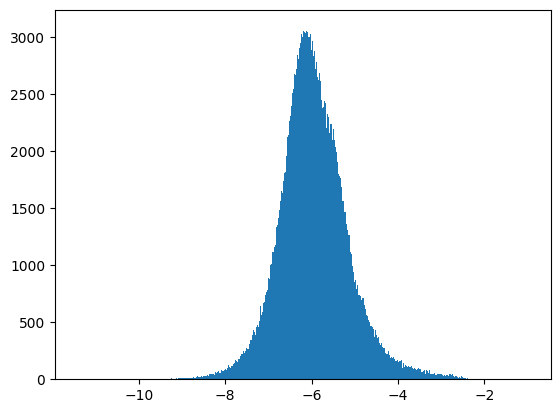

In [33]:
plt.hist(np.log10(grads), bins=1000);
# plt.xscale('log')